# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [21]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

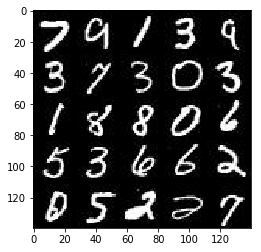

In [22]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

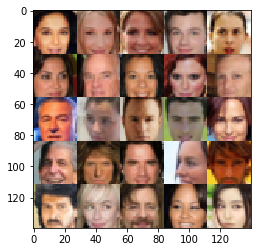

In [23]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [25]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_input_imgs = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels))
    z_data = tf.placeholder(tf.float32, (None,z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return real_input_imgs, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [49]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator',reuse=reuse):
        alpha = 0.2
        strides = 2
        padding = 'same'
        training = True
        dim = 28
        color_channels = 4
        # 28 x 28 x 3         
        x1 = tf.layers.conv2d(images,64,color_channels,strides=strides,padding=padding)
        relu1 = tf.maximum(alpha*x1,x1)
        # 14 x 14 x 64
                
        x2 = tf.layers.conv2d_transpose(relu1, 128, color_channels, strides=1, padding='valid')
        bn2 = tf.layers.batch_normalization(x2,training=training)
        relu2 = tf.maximum(alpha*bn2,bn2)
        # 7 x 7 x 128         
        
        x3 = tf.layers.conv2d(relu2,256,color_channels,strides=strides,padding=padding)
        bn3 = tf.layers.batch_normalization(x3,training=training)
        relu3 = tf.maximum(alpha*bn3,bn3)
        # 4 x 4 x 256
        
        x4 = tf.layers.conv2d(relu3,512,color_channels,strides=strides,padding=padding)
        bn4 = tf.layers.batch_normalization(x4,training=training)
        relu4 = tf.maximum(alpha*bn4,bn4)

        flat = tf.reshape(relu3,(-1,2*2*512))
        logits = tf.layers.dense(flat,1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [50]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator',reuse= not is_train):
        alpha = 0.2
        strides = 2
        padding = 'same'
        
        x1 = tf.layers.dense(z,2*2*512)
        
        x1 = tf.reshape(x1,(-1,2,2,512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha*x1,x1)
        # 2 x 2 x 256
        
        x2 = tf.layers.conv2d_transpose(x1,256,4,strides=strides,padding=padding)
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha*x2,x2)
        # 4 x 4 x 256 
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=1, padding='valid')
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(alpha*x3,x3)
        # 7 x 7 x 128
        
        x4 = tf.layers.conv2d_transpose(x3,64,4,strides=strides,padding=padding)
        x4 = tf.layers.batch_normalization(x4,training=is_train)
        x4 = tf.maximum(alpha*x4,x4)
        # 14 x 14 x 64
        logits = tf.layers.conv2d_transpose(x4,out_channel_dim,4,strides=strides,padding=padding)
        # 28 x 28 x c

        output = tf.tanh(logits)
    
    return output
        

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [51]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z,out_channel_dim, True)
    d_model_real,d_logits_real = discriminator(input_real, False)
    d_model_fake,d_logits_fake = discriminator(g_model, True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [52]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()

    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    

    d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [53]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [58]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print("DATA SHAPE", data_shape)
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    out_channel_dim = data_shape[3]
    
    input_real, input_z, learning = model_inputs(image_width,image_height,image_channels,z_dim)
    d_loss,g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

    batch_count = 0
    print_every = 10
    show_every = 100
    samples, losses = [], []
    # TODO: Build Model
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_count+=1
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                # TODO: Train Model
                
                
#     WIP Below this Line
                if batch_count % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if batch_count % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z, out_channel_dim, False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 9, input_z, out_channel_dim, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

DATA SHAPE (60000, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 1.3953... Generator Loss: 0.5605
Epoch 1/2... Discriminator Loss: 1.4262... Generator Loss: 0.6040
Epoch 1/2... Discriminator Loss: 1.4684... Generator Loss: 0.7059
Epoch 1/2... Discriminator Loss: 1.3757... Generator Loss: 0.7016
Epoch 1/2... Discriminator Loss: 1.3650... Generator Loss: 0.7811
Epoch 1/2... Discriminator Loss: 1.3160... Generator Loss: 0.7581
Epoch 1/2... Discriminator Loss: 1.2816... Generator Loss: 0.7720
Epoch 1/2... Discriminator Loss: 1.2638... Generator Loss: 0.7215
Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 0.7348
Epoch 1/2... Discriminator Loss: 1.2850... Generator Loss: 0.7761


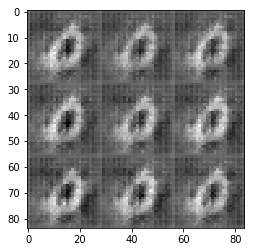

Epoch 1/2... Discriminator Loss: 1.3332... Generator Loss: 0.7155
Epoch 1/2... Discriminator Loss: 1.2559... Generator Loss: 0.7575
Epoch 1/2... Discriminator Loss: 1.2001... Generator Loss: 0.7903
Epoch 1/2... Discriminator Loss: 1.2494... Generator Loss: 0.8598
Epoch 1/2... Discriminator Loss: 1.1750... Generator Loss: 0.7642
Epoch 1/2... Discriminator Loss: 1.3071... Generator Loss: 0.7740
Epoch 1/2... Discriminator Loss: 1.2831... Generator Loss: 0.9477
Epoch 1/2... Discriminator Loss: 1.3124... Generator Loss: 0.6229
Epoch 1/2... Discriminator Loss: 1.1939... Generator Loss: 0.8389
Epoch 1/2... Discriminator Loss: 1.2903... Generator Loss: 0.7899


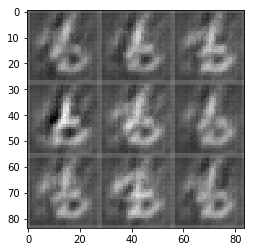

Epoch 1/2... Discriminator Loss: 1.2990... Generator Loss: 0.8862
Epoch 1/2... Discriminator Loss: 1.2763... Generator Loss: 0.7366
Epoch 1/2... Discriminator Loss: 1.2224... Generator Loss: 0.7310
Epoch 1/2... Discriminator Loss: 1.2604... Generator Loss: 0.8320
Epoch 1/2... Discriminator Loss: 1.3593... Generator Loss: 0.6747
Epoch 1/2... Discriminator Loss: 1.3052... Generator Loss: 0.6502
Epoch 1/2... Discriminator Loss: 1.2671... Generator Loss: 0.7051
Epoch 1/2... Discriminator Loss: 1.2343... Generator Loss: 0.6646
Epoch 1/2... Discriminator Loss: 1.2447... Generator Loss: 0.8903
Epoch 1/2... Discriminator Loss: 1.2196... Generator Loss: 0.8641


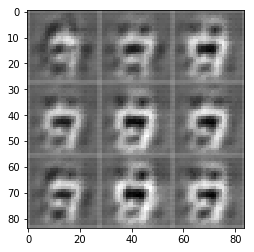

Epoch 1/2... Discriminator Loss: 1.2682... Generator Loss: 0.7927
Epoch 1/2... Discriminator Loss: 1.2870... Generator Loss: 0.8099
Epoch 1/2... Discriminator Loss: 1.2496... Generator Loss: 0.8254
Epoch 1/2... Discriminator Loss: 1.3542... Generator Loss: 0.7420
Epoch 1/2... Discriminator Loss: 1.2526... Generator Loss: 0.8539
Epoch 1/2... Discriminator Loss: 1.3042... Generator Loss: 0.8337
Epoch 1/2... Discriminator Loss: 1.3341... Generator Loss: 0.7726
Epoch 1/2... Discriminator Loss: 1.3443... Generator Loss: 0.7857
Epoch 1/2... Discriminator Loss: 1.3668... Generator Loss: 0.7523
Epoch 1/2... Discriminator Loss: 1.2888... Generator Loss: 0.7799


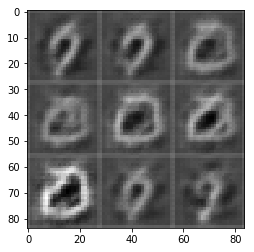

Epoch 1/2... Discriminator Loss: 1.2695... Generator Loss: 0.8417
Epoch 1/2... Discriminator Loss: 1.2915... Generator Loss: 0.7355
Epoch 1/2... Discriminator Loss: 1.3157... Generator Loss: 0.8170
Epoch 1/2... Discriminator Loss: 1.2038... Generator Loss: 0.7825
Epoch 1/2... Discriminator Loss: 1.2978... Generator Loss: 0.8627
Epoch 1/2... Discriminator Loss: 1.2773... Generator Loss: 0.8000
Epoch 1/2... Discriminator Loss: 1.3177... Generator Loss: 0.9179
Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 0.8000
Epoch 1/2... Discriminator Loss: 1.2781... Generator Loss: 0.7862
Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 0.7949


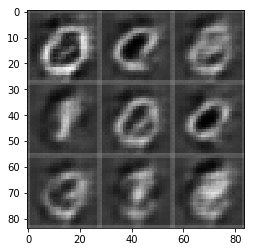

Epoch 1/2... Discriminator Loss: 1.3245... Generator Loss: 0.7758
Epoch 1/2... Discriminator Loss: 1.2927... Generator Loss: 0.7617
Epoch 1/2... Discriminator Loss: 1.2768... Generator Loss: 0.6864
Epoch 1/2... Discriminator Loss: 1.3294... Generator Loss: 0.8509
Epoch 1/2... Discriminator Loss: 1.3018... Generator Loss: 0.7801
Epoch 1/2... Discriminator Loss: 1.2978... Generator Loss: 0.8911
Epoch 1/2... Discriminator Loss: 1.3584... Generator Loss: 0.6788
Epoch 1/2... Discriminator Loss: 1.2987... Generator Loss: 0.7289
Epoch 1/2... Discriminator Loss: 1.3055... Generator Loss: 0.7857
Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 0.7321


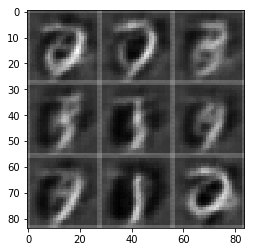

Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 0.7352
Epoch 1/2... Discriminator Loss: 1.3260... Generator Loss: 0.8539
Epoch 1/2... Discriminator Loss: 1.3605... Generator Loss: 0.8242
Epoch 1/2... Discriminator Loss: 1.3503... Generator Loss: 0.8455
Epoch 1/2... Discriminator Loss: 1.2730... Generator Loss: 0.7528
Epoch 1/2... Discriminator Loss: 1.3181... Generator Loss: 0.7062
Epoch 1/2... Discriminator Loss: 1.3246... Generator Loss: 0.6400
Epoch 1/2... Discriminator Loss: 1.3256... Generator Loss: 0.6683
Epoch 1/2... Discriminator Loss: 1.3044... Generator Loss: 0.8381
Epoch 1/2... Discriminator Loss: 1.3221... Generator Loss: 0.7752


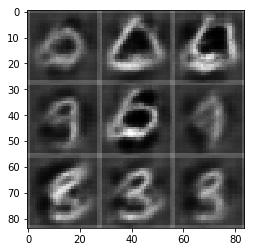

Epoch 1/2... Discriminator Loss: 1.3277... Generator Loss: 0.9014
Epoch 1/2... Discriminator Loss: 1.3340... Generator Loss: 0.7014
Epoch 1/2... Discriminator Loss: 1.3607... Generator Loss: 0.7305
Epoch 1/2... Discriminator Loss: 1.3119... Generator Loss: 0.7466
Epoch 1/2... Discriminator Loss: 1.2679... Generator Loss: 0.7709
Epoch 1/2... Discriminator Loss: 1.3828... Generator Loss: 0.8953
Epoch 1/2... Discriminator Loss: 1.2948... Generator Loss: 0.7840
Epoch 1/2... Discriminator Loss: 1.3641... Generator Loss: 0.7668
Epoch 1/2... Discriminator Loss: 1.3579... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 1.3668... Generator Loss: 0.6418


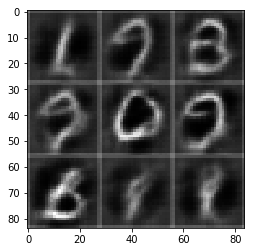

Epoch 1/2... Discriminator Loss: 1.3453... Generator Loss: 0.6795
Epoch 1/2... Discriminator Loss: 1.3063... Generator Loss: 0.7571
Epoch 1/2... Discriminator Loss: 1.3375... Generator Loss: 0.8596
Epoch 1/2... Discriminator Loss: 1.3133... Generator Loss: 0.8162
Epoch 1/2... Discriminator Loss: 1.3071... Generator Loss: 0.7450
Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 0.8326
Epoch 1/2... Discriminator Loss: 1.3115... Generator Loss: 0.8632
Epoch 1/2... Discriminator Loss: 1.3384... Generator Loss: 0.8672
Epoch 1/2... Discriminator Loss: 1.3122... Generator Loss: 0.7702
Epoch 1/2... Discriminator Loss: 1.3178... Generator Loss: 0.7031


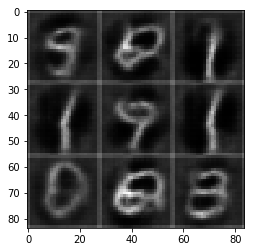

Epoch 1/2... Discriminator Loss: 1.3770... Generator Loss: 0.5317
Epoch 1/2... Discriminator Loss: 1.3018... Generator Loss: 0.6834
Epoch 1/2... Discriminator Loss: 1.3436... Generator Loss: 0.7053
Epoch 2/2... Discriminator Loss: 1.3644... Generator Loss: 0.5707
Epoch 2/2... Discriminator Loss: 1.3184... Generator Loss: 0.6271
Epoch 2/2... Discriminator Loss: 1.3024... Generator Loss: 0.7819
Epoch 2/2... Discriminator Loss: 1.3127... Generator Loss: 0.8731
Epoch 2/2... Discriminator Loss: 1.3295... Generator Loss: 0.9316
Epoch 2/2... Discriminator Loss: 1.3229... Generator Loss: 0.8232
Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.7049


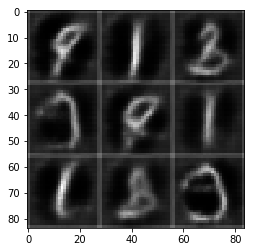

Epoch 2/2... Discriminator Loss: 1.3140... Generator Loss: 0.5921
Epoch 2/2... Discriminator Loss: 1.3453... Generator Loss: 0.7849
Epoch 2/2... Discriminator Loss: 1.3425... Generator Loss: 0.7815
Epoch 2/2... Discriminator Loss: 1.3123... Generator Loss: 0.7693
Epoch 2/2... Discriminator Loss: 1.3333... Generator Loss: 0.8503
Epoch 2/2... Discriminator Loss: 1.3323... Generator Loss: 0.8182
Epoch 2/2... Discriminator Loss: 1.3060... Generator Loss: 0.8630
Epoch 2/2... Discriminator Loss: 1.3169... Generator Loss: 0.8145
Epoch 2/2... Discriminator Loss: 1.2975... Generator Loss: 0.6806
Epoch 2/2... Discriminator Loss: 1.3399... Generator Loss: 0.8810


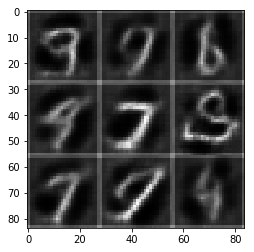

Epoch 2/2... Discriminator Loss: 1.4121... Generator Loss: 0.7582
Epoch 2/2... Discriminator Loss: 1.3163... Generator Loss: 0.8728
Epoch 2/2... Discriminator Loss: 1.3269... Generator Loss: 0.8450
Epoch 2/2... Discriminator Loss: 1.3203... Generator Loss: 0.8601
Epoch 2/2... Discriminator Loss: 1.3157... Generator Loss: 0.7057
Epoch 2/2... Discriminator Loss: 1.3283... Generator Loss: 0.9177
Epoch 2/2... Discriminator Loss: 1.3435... Generator Loss: 0.8253
Epoch 2/2... Discriminator Loss: 1.3512... Generator Loss: 0.8943
Epoch 2/2... Discriminator Loss: 1.2909... Generator Loss: 0.7958
Epoch 2/2... Discriminator Loss: 1.3098... Generator Loss: 0.8294


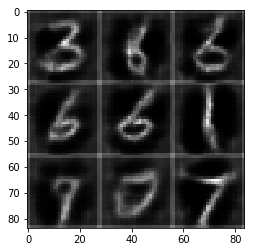

Epoch 2/2... Discriminator Loss: 1.3520... Generator Loss: 0.6312
Epoch 2/2... Discriminator Loss: 1.3561... Generator Loss: 0.5702
Epoch 2/2... Discriminator Loss: 1.3356... Generator Loss: 0.6315
Epoch 2/2... Discriminator Loss: 1.3600... Generator Loss: 0.7423
Epoch 2/2... Discriminator Loss: 1.5352... Generator Loss: 0.8823
Epoch 2/2... Discriminator Loss: 1.3494... Generator Loss: 0.7039
Epoch 2/2... Discriminator Loss: 1.3596... Generator Loss: 0.6880
Epoch 2/2... Discriminator Loss: 1.3579... Generator Loss: 0.6945
Epoch 2/2... Discriminator Loss: 1.3588... Generator Loss: 0.6719
Epoch 2/2... Discriminator Loss: 1.3614... Generator Loss: 0.6641


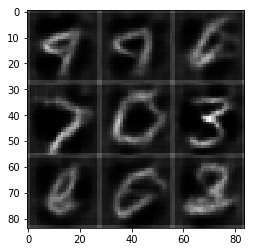

Epoch 2/2... Discriminator Loss: 1.3183... Generator Loss: 0.7117
Epoch 2/2... Discriminator Loss: 1.3279... Generator Loss: 0.7108
Epoch 2/2... Discriminator Loss: 1.3466... Generator Loss: 0.6966
Epoch 2/2... Discriminator Loss: 1.3260... Generator Loss: 0.6833
Epoch 2/2... Discriminator Loss: 1.3144... Generator Loss: 0.7864
Epoch 2/2... Discriminator Loss: 1.3134... Generator Loss: 0.7969
Epoch 2/2... Discriminator Loss: 1.3277... Generator Loss: 0.8559
Epoch 2/2... Discriminator Loss: 1.3156... Generator Loss: 0.8467
Epoch 2/2... Discriminator Loss: 1.3638... Generator Loss: 0.7250
Epoch 2/2... Discriminator Loss: 1.3223... Generator Loss: 0.8401


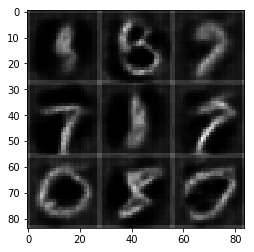

Epoch 2/2... Discriminator Loss: 1.3090... Generator Loss: 0.8195
Epoch 2/2... Discriminator Loss: 1.3551... Generator Loss: 0.9871
Epoch 2/2... Discriminator Loss: 1.3388... Generator Loss: 0.6044
Epoch 2/2... Discriminator Loss: 1.3651... Generator Loss: 0.5798
Epoch 2/2... Discriminator Loss: 1.3370... Generator Loss: 0.6264
Epoch 2/2... Discriminator Loss: 1.3141... Generator Loss: 0.7297
Epoch 2/2... Discriminator Loss: 1.2620... Generator Loss: 0.7910
Epoch 2/2... Discriminator Loss: 1.3157... Generator Loss: 0.8982
Epoch 2/2... Discriminator Loss: 1.3462... Generator Loss: 0.8827
Epoch 2/2... Discriminator Loss: 1.3170... Generator Loss: 0.7194


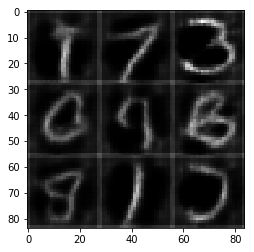

Epoch 2/2... Discriminator Loss: 1.3517... Generator Loss: 0.6070
Epoch 2/2... Discriminator Loss: 1.3466... Generator Loss: 0.9129
Epoch 2/2... Discriminator Loss: 1.3060... Generator Loss: 0.8004
Epoch 2/2... Discriminator Loss: 1.3662... Generator Loss: 0.9699
Epoch 2/2... Discriminator Loss: 1.2852... Generator Loss: 0.8382
Epoch 2/2... Discriminator Loss: 1.3113... Generator Loss: 0.8645
Epoch 2/2... Discriminator Loss: 1.2789... Generator Loss: 0.8512
Epoch 2/2... Discriminator Loss: 1.3081... Generator Loss: 0.7233
Epoch 2/2... Discriminator Loss: 1.3289... Generator Loss: 0.8906
Epoch 2/2... Discriminator Loss: 1.3070... Generator Loss: 0.8574


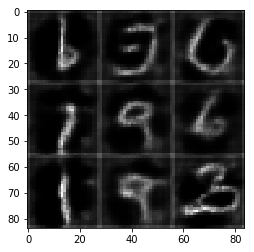

Epoch 2/2... Discriminator Loss: 1.3445... Generator Loss: 0.9577
Epoch 2/2... Discriminator Loss: 1.3014... Generator Loss: 0.7433
Epoch 2/2... Discriminator Loss: 1.3140... Generator Loss: 0.5742
Epoch 2/2... Discriminator Loss: 1.2932... Generator Loss: 0.6469
Epoch 2/2... Discriminator Loss: 1.2940... Generator Loss: 0.6746
Epoch 2/2... Discriminator Loss: 1.3747... Generator Loss: 0.5179
Epoch 2/2... Discriminator Loss: 1.2856... Generator Loss: 0.7044
Epoch 2/2... Discriminator Loss: 1.3119... Generator Loss: 0.7444
Epoch 2/2... Discriminator Loss: 1.4763... Generator Loss: 0.7344
Epoch 2/2... Discriminator Loss: 1.3617... Generator Loss: 0.7207


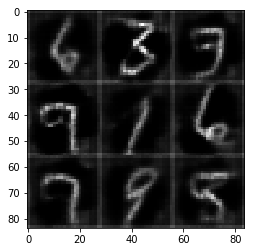

Epoch 2/2... Discriminator Loss: 1.3380... Generator Loss: 0.6758
Epoch 2/2... Discriminator Loss: 1.2870... Generator Loss: 0.7186
Epoch 2/2... Discriminator Loss: 1.3152... Generator Loss: 0.7999
Epoch 2/2... Discriminator Loss: 1.3093... Generator Loss: 0.8869
Epoch 2/2... Discriminator Loss: 1.3025... Generator Loss: 0.7992
Epoch 2/2... Discriminator Loss: 1.2843... Generator Loss: 0.8217
Epoch 2/2... Discriminator Loss: 1.2594... Generator Loss: 0.7821
Epoch 2/2... Discriminator Loss: 1.2476... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 1.3295... Generator Loss: 0.9864
Epoch 2/2... Discriminator Loss: 1.2962... Generator Loss: 0.7371


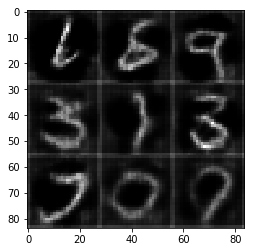

Epoch 2/2... Discriminator Loss: 1.3020... Generator Loss: 1.0295
Epoch 2/2... Discriminator Loss: 1.2916... Generator Loss: 0.6915
Epoch 2/2... Discriminator Loss: 1.3497... Generator Loss: 0.5627
Epoch 2/2... Discriminator Loss: 1.2735... Generator Loss: 0.7646
Epoch 2/2... Discriminator Loss: 1.2529... Generator Loss: 0.7719
Epoch 2/2... Discriminator Loss: 1.3105... Generator Loss: 0.8892
Epoch 2/2... Discriminator Loss: 1.3367... Generator Loss: 1.0063


NameError: name 'pkl' is not defined

In [56]:
learning_rate = 0.0004
batch_size = 64
z_dim = 100
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

DATA SHAPE (202599, 28, 28, 3)
Epoch 1/5... Discriminator Loss: 1.4630... Generator Loss: 0.6195
Epoch 1/5... Discriminator Loss: 1.3529... Generator Loss: 0.7721
Epoch 1/5... Discriminator Loss: 1.1664... Generator Loss: 0.8558
Epoch 1/5... Discriminator Loss: 1.1872... Generator Loss: 0.8860
Epoch 1/5... Discriminator Loss: 1.3437... Generator Loss: 0.7655
Epoch 1/5... Discriminator Loss: 1.1941... Generator Loss: 0.8156
Epoch 1/5... Discriminator Loss: 1.1977... Generator Loss: 0.8724
Epoch 1/5... Discriminator Loss: 1.2504... Generator Loss: 0.8060
Epoch 1/5... Discriminator Loss: 1.2575... Generator Loss: 0.8586
Epoch 1/5... Discriminator Loss: 0.9973... Generator Loss: 0.9514


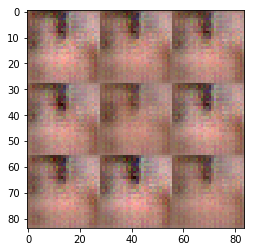

Epoch 1/5... Discriminator Loss: 1.2824... Generator Loss: 0.8461
Epoch 1/5... Discriminator Loss: 1.1831... Generator Loss: 0.8531
Epoch 1/5... Discriminator Loss: 1.3427... Generator Loss: 0.7679
Epoch 1/5... Discriminator Loss: 1.3352... Generator Loss: 0.6986
Epoch 1/5... Discriminator Loss: 1.2594... Generator Loss: 0.7390
Epoch 1/5... Discriminator Loss: 1.3643... Generator Loss: 0.7342
Epoch 1/5... Discriminator Loss: 1.4011... Generator Loss: 0.7763
Epoch 1/5... Discriminator Loss: 1.3272... Generator Loss: 0.6906
Epoch 1/5... Discriminator Loss: 1.3054... Generator Loss: 0.7578
Epoch 1/5... Discriminator Loss: 1.2536... Generator Loss: 0.7616


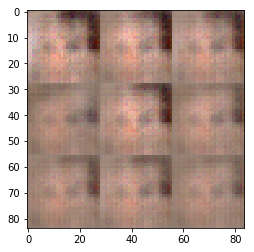

Epoch 1/5... Discriminator Loss: 1.2819... Generator Loss: 0.6818
Epoch 1/5... Discriminator Loss: 1.3013... Generator Loss: 0.7941
Epoch 1/5... Discriminator Loss: 1.2443... Generator Loss: 0.8410
Epoch 1/5... Discriminator Loss: 1.2975... Generator Loss: 0.8147
Epoch 1/5... Discriminator Loss: 1.3249... Generator Loss: 0.6500
Epoch 1/5... Discriminator Loss: 1.2237... Generator Loss: 0.8952
Epoch 1/5... Discriminator Loss: 1.2903... Generator Loss: 0.7998
Epoch 1/5... Discriminator Loss: 1.2896... Generator Loss: 0.9353
Epoch 1/5... Discriminator Loss: 1.3448... Generator Loss: 0.9236
Epoch 1/5... Discriminator Loss: 1.3514... Generator Loss: 0.8565


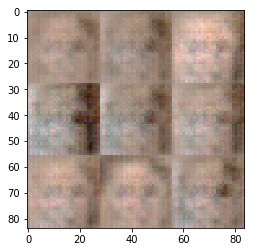

Epoch 1/5... Discriminator Loss: 1.3318... Generator Loss: 0.9976
Epoch 1/5... Discriminator Loss: 1.3285... Generator Loss: 0.6620
Epoch 1/5... Discriminator Loss: 1.3397... Generator Loss: 0.7686
Epoch 1/5... Discriminator Loss: 1.2615... Generator Loss: 0.8808
Epoch 1/5... Discriminator Loss: 1.2708... Generator Loss: 0.7174
Epoch 1/5... Discriminator Loss: 1.2585... Generator Loss: 0.7831
Epoch 1/5... Discriminator Loss: 1.3095... Generator Loss: 0.9133
Epoch 1/5... Discriminator Loss: 1.2704... Generator Loss: 0.8024
Epoch 1/5... Discriminator Loss: 1.3523... Generator Loss: 0.7512
Epoch 1/5... Discriminator Loss: 1.3333... Generator Loss: 0.6743


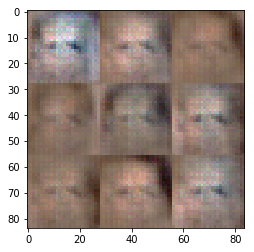

Epoch 1/5... Discriminator Loss: 1.3368... Generator Loss: 0.7657
Epoch 1/5... Discriminator Loss: 1.2500... Generator Loss: 0.7317
Epoch 1/5... Discriminator Loss: 1.2851... Generator Loss: 0.8056
Epoch 1/5... Discriminator Loss: 1.2820... Generator Loss: 0.7107
Epoch 1/5... Discriminator Loss: 1.2741... Generator Loss: 0.8467
Epoch 1/5... Discriminator Loss: 1.3419... Generator Loss: 0.9904
Epoch 1/5... Discriminator Loss: 1.2706... Generator Loss: 0.7801
Epoch 1/5... Discriminator Loss: 1.3452... Generator Loss: 0.5996
Epoch 1/5... Discriminator Loss: 1.2998... Generator Loss: 0.7798
Epoch 1/5... Discriminator Loss: 1.2777... Generator Loss: 0.6803


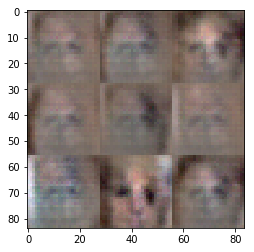

Epoch 1/5... Discriminator Loss: 1.2865... Generator Loss: 0.8020
Epoch 1/5... Discriminator Loss: 1.2575... Generator Loss: 0.8174
Epoch 1/5... Discriminator Loss: 1.2588... Generator Loss: 0.7568
Epoch 1/5... Discriminator Loss: 1.2718... Generator Loss: 0.7837
Epoch 1/5... Discriminator Loss: 1.2679... Generator Loss: 0.8628
Epoch 1/5... Discriminator Loss: 1.2656... Generator Loss: 0.8250
Epoch 1/5... Discriminator Loss: 1.3085... Generator Loss: 0.7516
Epoch 1/5... Discriminator Loss: 1.3008... Generator Loss: 0.7678
Epoch 1/5... Discriminator Loss: 1.2606... Generator Loss: 0.7353
Epoch 1/5... Discriminator Loss: 1.3755... Generator Loss: 0.6221


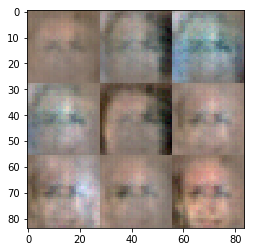

Epoch 1/5... Discriminator Loss: 1.2675... Generator Loss: 0.7958
Epoch 1/5... Discriminator Loss: 1.3172... Generator Loss: 0.6476
Epoch 1/5... Discriminator Loss: 1.3434... Generator Loss: 0.9380
Epoch 1/5... Discriminator Loss: 1.3256... Generator Loss: 0.6698
Epoch 1/5... Discriminator Loss: 1.3392... Generator Loss: 0.6560
Epoch 1/5... Discriminator Loss: 1.2704... Generator Loss: 0.7620
Epoch 1/5... Discriminator Loss: 1.2504... Generator Loss: 0.7814
Epoch 1/5... Discriminator Loss: 1.3558... Generator Loss: 0.5513
Epoch 1/5... Discriminator Loss: 1.2394... Generator Loss: 0.8320
Epoch 1/5... Discriminator Loss: 1.2738... Generator Loss: 0.8960


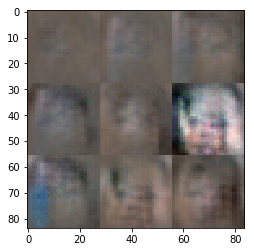

Epoch 1/5... Discriminator Loss: 1.2565... Generator Loss: 0.8563
Epoch 1/5... Discriminator Loss: 1.3162... Generator Loss: 0.9001
Epoch 1/5... Discriminator Loss: 1.3689... Generator Loss: 0.8394
Epoch 1/5... Discriminator Loss: 1.2739... Generator Loss: 0.7853
Epoch 1/5... Discriminator Loss: 1.2734... Generator Loss: 0.7218
Epoch 1/5... Discriminator Loss: 1.2679... Generator Loss: 0.8619
Epoch 1/5... Discriminator Loss: 1.2806... Generator Loss: 0.9216
Epoch 1/5... Discriminator Loss: 1.3071... Generator Loss: 0.9308
Epoch 1/5... Discriminator Loss: 1.3164... Generator Loss: 0.8434
Epoch 1/5... Discriminator Loss: 1.3105... Generator Loss: 0.6132


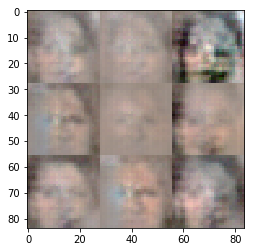

Epoch 1/5... Discriminator Loss: 1.3601... Generator Loss: 0.7637
Epoch 1/5... Discriminator Loss: 1.3139... Generator Loss: 0.6428
Epoch 1/5... Discriminator Loss: 1.3387... Generator Loss: 0.8458
Epoch 1/5... Discriminator Loss: 1.2942... Generator Loss: 0.7406
Epoch 1/5... Discriminator Loss: 1.3046... Generator Loss: 0.8463
Epoch 1/5... Discriminator Loss: 1.3013... Generator Loss: 0.7064
Epoch 1/5... Discriminator Loss: 1.2674... Generator Loss: 0.9102
Epoch 1/5... Discriminator Loss: 1.3064... Generator Loss: 0.7708
Epoch 1/5... Discriminator Loss: 1.2718... Generator Loss: 0.7471
Epoch 1/5... Discriminator Loss: 1.2854... Generator Loss: 0.6798


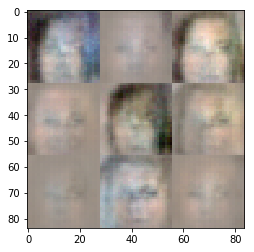

Epoch 1/5... Discriminator Loss: 1.3103... Generator Loss: 0.8922
Epoch 1/5... Discriminator Loss: 1.2901... Generator Loss: 0.9478
Epoch 1/5... Discriminator Loss: 1.6795... Generator Loss: 0.8505
Epoch 1/5... Discriminator Loss: 1.3827... Generator Loss: 0.7174
Epoch 1/5... Discriminator Loss: 1.4123... Generator Loss: 0.7292
Epoch 1/5... Discriminator Loss: 1.3958... Generator Loss: 0.7119
Epoch 1/5... Discriminator Loss: 1.3812... Generator Loss: 0.6940
Epoch 1/5... Discriminator Loss: 1.3817... Generator Loss: 0.7160
Epoch 1/5... Discriminator Loss: 1.3049... Generator Loss: 0.7590
Epoch 1/5... Discriminator Loss: 1.3228... Generator Loss: 0.7636


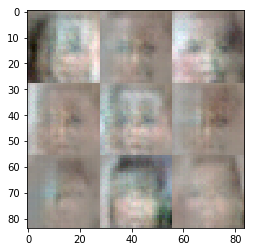

Epoch 1/5... Discriminator Loss: 1.2875... Generator Loss: 0.7746
Epoch 1/5... Discriminator Loss: 1.3204... Generator Loss: 0.7220
Epoch 1/5... Discriminator Loss: 1.3134... Generator Loss: 0.7915
Epoch 1/5... Discriminator Loss: 1.3141... Generator Loss: 0.6967
Epoch 1/5... Discriminator Loss: 1.3368... Generator Loss: 0.6627
Epoch 1/5... Discriminator Loss: 1.3240... Generator Loss: 0.6674
Epoch 1/5... Discriminator Loss: 1.3230... Generator Loss: 0.6911
Epoch 1/5... Discriminator Loss: 1.3083... Generator Loss: 0.6862
Epoch 1/5... Discriminator Loss: 1.3543... Generator Loss: 0.7132
Epoch 1/5... Discriminator Loss: 1.2975... Generator Loss: 0.7800


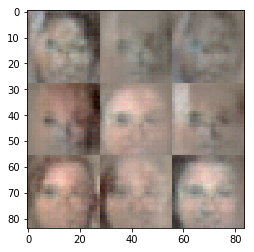

Epoch 1/5... Discriminator Loss: 1.3518... Generator Loss: 0.6476
Epoch 1/5... Discriminator Loss: 1.2785... Generator Loss: 0.7937
Epoch 1/5... Discriminator Loss: 1.2931... Generator Loss: 0.6641
Epoch 1/5... Discriminator Loss: 1.2722... Generator Loss: 0.7509
Epoch 1/5... Discriminator Loss: 1.2860... Generator Loss: 0.8407
Epoch 1/5... Discriminator Loss: 1.4256... Generator Loss: 0.6248
Epoch 1/5... Discriminator Loss: 1.3507... Generator Loss: 0.6149
Epoch 1/5... Discriminator Loss: 1.3693... Generator Loss: 0.6923
Epoch 1/5... Discriminator Loss: 1.3145... Generator Loss: 0.6091
Epoch 1/5... Discriminator Loss: 1.3058... Generator Loss: 0.7252


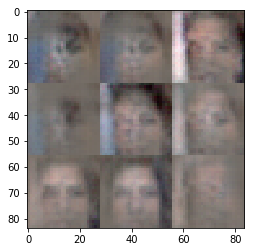

Epoch 1/5... Discriminator Loss: 1.3225... Generator Loss: 0.6632
Epoch 1/5... Discriminator Loss: 1.3456... Generator Loss: 0.6641
Epoch 1/5... Discriminator Loss: 1.3282... Generator Loss: 0.6855
Epoch 1/5... Discriminator Loss: 1.2842... Generator Loss: 0.7440
Epoch 1/5... Discriminator Loss: 1.3113... Generator Loss: 0.6631
Epoch 1/5... Discriminator Loss: 1.3486... Generator Loss: 0.6071
Epoch 1/5... Discriminator Loss: 1.3604... Generator Loss: 0.7203
Epoch 1/5... Discriminator Loss: 1.3367... Generator Loss: 0.8316
Epoch 1/5... Discriminator Loss: 1.3246... Generator Loss: 0.6909
Epoch 1/5... Discriminator Loss: 1.3748... Generator Loss: 0.6162


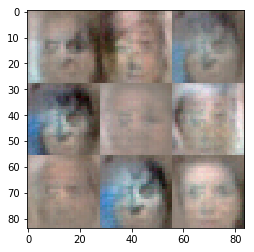

Epoch 1/5... Discriminator Loss: 1.3361... Generator Loss: 0.5914
Epoch 1/5... Discriminator Loss: 1.2805... Generator Loss: 0.8180
Epoch 1/5... Discriminator Loss: 1.3366... Generator Loss: 0.7741
Epoch 1/5... Discriminator Loss: 1.2688... Generator Loss: 0.7976
Epoch 1/5... Discriminator Loss: 1.3485... Generator Loss: 0.7682
Epoch 1/5... Discriminator Loss: 1.2786... Generator Loss: 0.7947
Epoch 1/5... Discriminator Loss: 1.2351... Generator Loss: 0.7486
Epoch 1/5... Discriminator Loss: 1.3992... Generator Loss: 0.8116
Epoch 1/5... Discriminator Loss: 1.3594... Generator Loss: 0.5975
Epoch 1/5... Discriminator Loss: 1.3825... Generator Loss: 0.5389


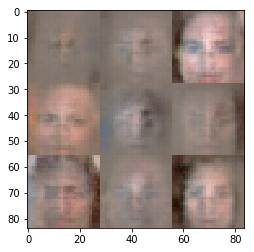

Epoch 1/5... Discriminator Loss: 1.3035... Generator Loss: 0.7056
Epoch 1/5... Discriminator Loss: 1.3870... Generator Loss: 0.8009
Epoch 1/5... Discriminator Loss: 1.3221... Generator Loss: 0.7524
Epoch 1/5... Discriminator Loss: 1.3776... Generator Loss: 0.5850
Epoch 1/5... Discriminator Loss: 1.3013... Generator Loss: 0.7726
Epoch 1/5... Discriminator Loss: 1.3359... Generator Loss: 0.7085
Epoch 1/5... Discriminator Loss: 1.3012... Generator Loss: 0.7396
Epoch 1/5... Discriminator Loss: 1.2550... Generator Loss: 0.7200
Epoch 1/5... Discriminator Loss: 1.3150... Generator Loss: 0.7662
Epoch 1/5... Discriminator Loss: 1.3033... Generator Loss: 0.7544


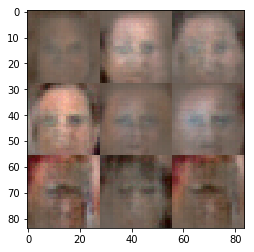

Epoch 1/5... Discriminator Loss: 1.3144... Generator Loss: 0.7732
Epoch 1/5... Discriminator Loss: 1.3634... Generator Loss: 0.7148
Epoch 1/5... Discriminator Loss: 1.3357... Generator Loss: 0.8551
Epoch 1/5... Discriminator Loss: 1.3626... Generator Loss: 0.7635
Epoch 1/5... Discriminator Loss: 1.3263... Generator Loss: 0.6966
Epoch 1/5... Discriminator Loss: 1.2741... Generator Loss: 0.6791
Epoch 1/5... Discriminator Loss: 1.4060... Generator Loss: 0.6010
Epoch 1/5... Discriminator Loss: 1.3212... Generator Loss: 0.7197
Epoch 2/5... Discriminator Loss: 1.3576... Generator Loss: 0.6950
Epoch 2/5... Discriminator Loss: 1.3265... Generator Loss: 0.6211


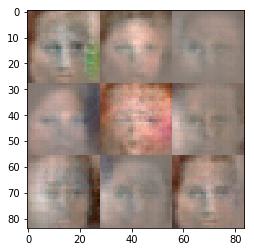

Epoch 2/5... Discriminator Loss: 1.3456... Generator Loss: 0.6710
Epoch 2/5... Discriminator Loss: 1.2899... Generator Loss: 0.7329
Epoch 2/5... Discriminator Loss: 1.3163... Generator Loss: 0.7301
Epoch 2/5... Discriminator Loss: 1.3288... Generator Loss: 0.7716
Epoch 2/5... Discriminator Loss: 1.3623... Generator Loss: 0.7646
Epoch 2/5... Discriminator Loss: 1.3878... Generator Loss: 0.8578
Epoch 2/5... Discriminator Loss: 1.7341... Generator Loss: 0.8547
Epoch 2/5... Discriminator Loss: 1.4483... Generator Loss: 0.7934
Epoch 2/5... Discriminator Loss: 1.4069... Generator Loss: 0.6703
Epoch 2/5... Discriminator Loss: 1.3874... Generator Loss: 0.7070


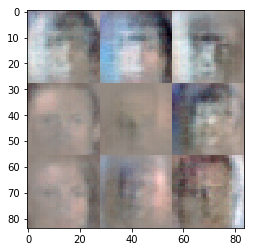

Epoch 2/5... Discriminator Loss: 1.3238... Generator Loss: 0.7481
Epoch 2/5... Discriminator Loss: 1.3127... Generator Loss: 0.7239
Epoch 2/5... Discriminator Loss: 1.3543... Generator Loss: 0.6716
Epoch 2/5... Discriminator Loss: 1.3543... Generator Loss: 0.6872
Epoch 2/5... Discriminator Loss: 1.3362... Generator Loss: 0.7069
Epoch 2/5... Discriminator Loss: 1.3452... Generator Loss: 0.7169
Epoch 2/5... Discriminator Loss: 1.3336... Generator Loss: 0.6921
Epoch 2/5... Discriminator Loss: 1.2965... Generator Loss: 0.7381
Epoch 2/5... Discriminator Loss: 1.3113... Generator Loss: 0.7333
Epoch 2/5... Discriminator Loss: 1.3007... Generator Loss: 0.7781


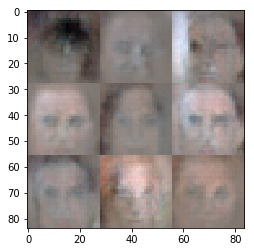

Epoch 2/5... Discriminator Loss: 1.3192... Generator Loss: 0.7507
Epoch 2/5... Discriminator Loss: 1.3111... Generator Loss: 0.7510
Epoch 2/5... Discriminator Loss: 1.3588... Generator Loss: 0.7415
Epoch 2/5... Discriminator Loss: 1.3089... Generator Loss: 0.7338
Epoch 2/5... Discriminator Loss: 1.2817... Generator Loss: 0.7444
Epoch 2/5... Discriminator Loss: 1.3126... Generator Loss: 0.7123
Epoch 2/5... Discriminator Loss: 1.3294... Generator Loss: 0.6607
Epoch 2/5... Discriminator Loss: 1.3393... Generator Loss: 0.6496
Epoch 2/5... Discriminator Loss: 1.3093... Generator Loss: 0.7512
Epoch 2/5... Discriminator Loss: 1.3227... Generator Loss: 0.7126


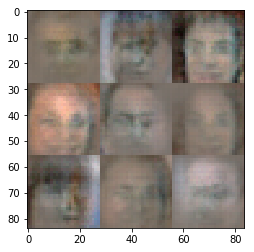

Epoch 2/5... Discriminator Loss: 1.3479... Generator Loss: 0.7676
Epoch 2/5... Discriminator Loss: 1.3471... Generator Loss: 0.7318
Epoch 2/5... Discriminator Loss: 1.3904... Generator Loss: 0.5912
Epoch 2/5... Discriminator Loss: 1.3375... Generator Loss: 0.7092
Epoch 2/5... Discriminator Loss: 1.3271... Generator Loss: 0.7703
Epoch 2/5... Discriminator Loss: 1.3625... Generator Loss: 0.6780
Epoch 2/5... Discriminator Loss: 1.3253... Generator Loss: 0.7369
Epoch 2/5... Discriminator Loss: 1.3464... Generator Loss: 0.6867
Epoch 2/5... Discriminator Loss: 1.2872... Generator Loss: 0.7981
Epoch 2/5... Discriminator Loss: 1.3359... Generator Loss: 0.7350


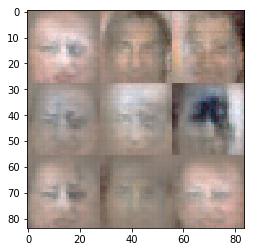

Epoch 2/5... Discriminator Loss: 1.3667... Generator Loss: 0.7162
Epoch 2/5... Discriminator Loss: 1.3447... Generator Loss: 0.6401
Epoch 2/5... Discriminator Loss: 1.3263... Generator Loss: 0.7375
Epoch 2/5... Discriminator Loss: 1.3233... Generator Loss: 0.7391
Epoch 2/5... Discriminator Loss: 1.3434... Generator Loss: 0.6390
Epoch 2/5... Discriminator Loss: 1.3850... Generator Loss: 0.7476
Epoch 2/5... Discriminator Loss: 1.3321... Generator Loss: 0.7449
Epoch 2/5... Discriminator Loss: 1.3745... Generator Loss: 0.6080
Epoch 2/5... Discriminator Loss: 1.4011... Generator Loss: 0.6051
Epoch 2/5... Discriminator Loss: 1.3448... Generator Loss: 0.6944


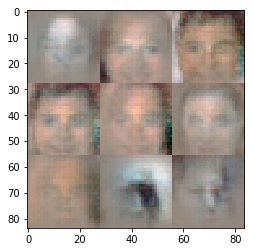

Epoch 2/5... Discriminator Loss: 1.3486... Generator Loss: 0.7181
Epoch 2/5... Discriminator Loss: 1.3256... Generator Loss: 0.6780
Epoch 2/5... Discriminator Loss: 1.3567... Generator Loss: 0.7220
Epoch 2/5... Discriminator Loss: 1.3415... Generator Loss: 0.8177
Epoch 2/5... Discriminator Loss: 1.3377... Generator Loss: 0.8735
Epoch 2/5... Discriminator Loss: 1.3296... Generator Loss: 0.8661
Epoch 2/5... Discriminator Loss: 1.4041... Generator Loss: 0.6627
Epoch 2/5... Discriminator Loss: 1.3865... Generator Loss: 0.6156
Epoch 2/5... Discriminator Loss: 1.3625... Generator Loss: 0.6292
Epoch 2/5... Discriminator Loss: 1.2897... Generator Loss: 0.7220


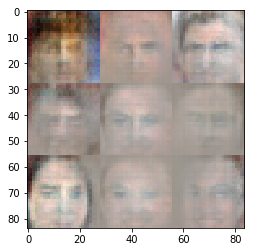

Epoch 2/5... Discriminator Loss: 1.3401... Generator Loss: 0.7381
Epoch 2/5... Discriminator Loss: 1.2934... Generator Loss: 0.7886
Epoch 2/5... Discriminator Loss: 1.2955... Generator Loss: 0.7661
Epoch 2/5... Discriminator Loss: 1.3171... Generator Loss: 0.5792
Epoch 2/5... Discriminator Loss: 1.3087... Generator Loss: 0.7555
Epoch 2/5... Discriminator Loss: 1.2681... Generator Loss: 0.8284
Epoch 2/5... Discriminator Loss: 1.2387... Generator Loss: 0.9128
Epoch 2/5... Discriminator Loss: 1.3105... Generator Loss: 0.8114
Epoch 2/5... Discriminator Loss: 1.3157... Generator Loss: 0.9034
Epoch 2/5... Discriminator Loss: 1.4423... Generator Loss: 0.8087


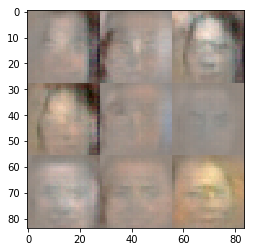

Epoch 2/5... Discriminator Loss: 1.2985... Generator Loss: 0.7486
Epoch 2/5... Discriminator Loss: 1.4056... Generator Loss: 0.6675
Epoch 2/5... Discriminator Loss: 1.4120... Generator Loss: 0.6551
Epoch 2/5... Discriminator Loss: 1.4149... Generator Loss: 0.6561
Epoch 2/5... Discriminator Loss: 1.3989... Generator Loss: 0.6911
Epoch 2/5... Discriminator Loss: 1.3902... Generator Loss: 0.7044
Epoch 2/5... Discriminator Loss: 1.3979... Generator Loss: 0.6880
Epoch 2/5... Discriminator Loss: 1.4032... Generator Loss: 0.6742
Epoch 2/5... Discriminator Loss: 1.4037... Generator Loss: 0.6864
Epoch 2/5... Discriminator Loss: 1.3887... Generator Loss: 0.6940


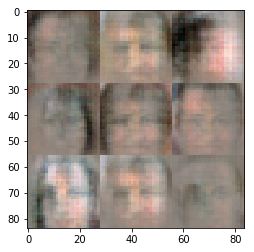

Epoch 2/5... Discriminator Loss: 1.3790... Generator Loss: 0.7074
Epoch 2/5... Discriminator Loss: 1.3948... Generator Loss: 0.6830
Epoch 2/5... Discriminator Loss: 1.4034... Generator Loss: 0.6844
Epoch 2/5... Discriminator Loss: 1.4011... Generator Loss: 0.6846
Epoch 2/5... Discriminator Loss: 1.3911... Generator Loss: 0.6950
Epoch 2/5... Discriminator Loss: 1.3869... Generator Loss: 0.6900
Epoch 2/5... Discriminator Loss: 1.3846... Generator Loss: 0.6978
Epoch 2/5... Discriminator Loss: 1.3943... Generator Loss: 0.6796
Epoch 2/5... Discriminator Loss: 1.3952... Generator Loss: 0.6844
Epoch 2/5... Discriminator Loss: 1.3812... Generator Loss: 0.6892


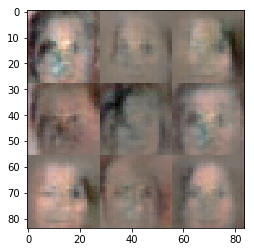

Epoch 2/5... Discriminator Loss: 1.4065... Generator Loss: 0.6882
Epoch 2/5... Discriminator Loss: 1.3867... Generator Loss: 0.6803
Epoch 2/5... Discriminator Loss: 1.3964... Generator Loss: 0.6948
Epoch 2/5... Discriminator Loss: 1.3950... Generator Loss: 0.6818
Epoch 2/5... Discriminator Loss: 1.3849... Generator Loss: 0.7061
Epoch 2/5... Discriminator Loss: 1.3897... Generator Loss: 0.7058
Epoch 2/5... Discriminator Loss: 1.3853... Generator Loss: 0.6951
Epoch 2/5... Discriminator Loss: 1.3878... Generator Loss: 0.6886
Epoch 2/5... Discriminator Loss: 1.3921... Generator Loss: 0.6944
Epoch 2/5... Discriminator Loss: 1.3853... Generator Loss: 0.7003


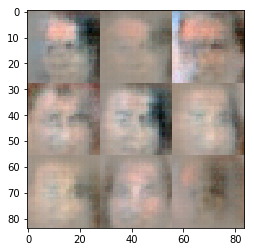

Epoch 2/5... Discriminator Loss: 1.3888... Generator Loss: 0.6845
Epoch 2/5... Discriminator Loss: 1.3927... Generator Loss: 0.6876
Epoch 2/5... Discriminator Loss: 1.3903... Generator Loss: 0.6921
Epoch 2/5... Discriminator Loss: 1.3871... Generator Loss: 0.6849
Epoch 2/5... Discriminator Loss: 1.3893... Generator Loss: 0.6815
Epoch 2/5... Discriminator Loss: 1.3884... Generator Loss: 0.6912
Epoch 2/5... Discriminator Loss: 1.3886... Generator Loss: 0.6770
Epoch 2/5... Discriminator Loss: 1.3837... Generator Loss: 0.6879
Epoch 2/5... Discriminator Loss: 1.3979... Generator Loss: 0.6929
Epoch 2/5... Discriminator Loss: 1.3846... Generator Loss: 0.7013


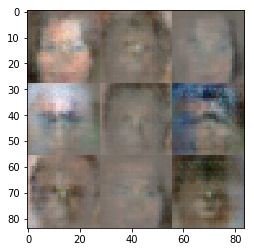

Epoch 2/5... Discriminator Loss: 1.3911... Generator Loss: 0.6942
Epoch 2/5... Discriminator Loss: 1.3835... Generator Loss: 0.7055
Epoch 2/5... Discriminator Loss: 1.3851... Generator Loss: 0.6836
Epoch 2/5... Discriminator Loss: 1.3883... Generator Loss: 0.6964
Epoch 2/5... Discriminator Loss: 1.3894... Generator Loss: 0.6948
Epoch 2/5... Discriminator Loss: 1.3910... Generator Loss: 0.6765
Epoch 2/5... Discriminator Loss: 1.3899... Generator Loss: 0.6973
Epoch 2/5... Discriminator Loss: 1.3934... Generator Loss: 0.7064
Epoch 2/5... Discriminator Loss: 1.3852... Generator Loss: 0.6710
Epoch 2/5... Discriminator Loss: 1.3864... Generator Loss: 0.7057


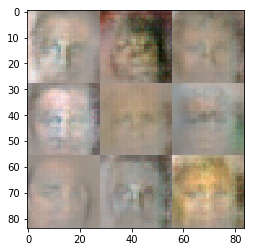

Epoch 2/5... Discriminator Loss: 1.3857... Generator Loss: 0.6973
Epoch 2/5... Discriminator Loss: 1.3951... Generator Loss: 0.6934
Epoch 2/5... Discriminator Loss: 1.3903... Generator Loss: 0.6905
Epoch 2/5... Discriminator Loss: 1.3933... Generator Loss: 0.6942
Epoch 2/5... Discriminator Loss: 1.3833... Generator Loss: 0.6973
Epoch 2/5... Discriminator Loss: 1.3843... Generator Loss: 0.6940
Epoch 2/5... Discriminator Loss: 1.3855... Generator Loss: 0.6949
Epoch 2/5... Discriminator Loss: 1.3878... Generator Loss: 0.7169
Epoch 2/5... Discriminator Loss: 1.3877... Generator Loss: 0.7084
Epoch 2/5... Discriminator Loss: 1.3853... Generator Loss: 0.6874


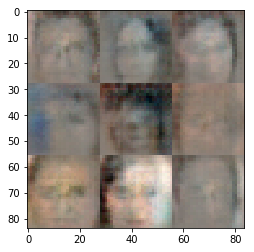

Epoch 2/5... Discriminator Loss: 1.3844... Generator Loss: 0.6999
Epoch 2/5... Discriminator Loss: 1.3885... Generator Loss: 0.6943
Epoch 2/5... Discriminator Loss: 1.3900... Generator Loss: 0.6951
Epoch 2/5... Discriminator Loss: 1.3872... Generator Loss: 0.7146
Epoch 2/5... Discriminator Loss: 1.3907... Generator Loss: 0.7154
Epoch 2/5... Discriminator Loss: 1.3805... Generator Loss: 0.7086
Epoch 2/5... Discriminator Loss: 1.3871... Generator Loss: 0.6918
Epoch 2/5... Discriminator Loss: 1.3885... Generator Loss: 0.7171
Epoch 2/5... Discriminator Loss: 1.3890... Generator Loss: 0.7037
Epoch 2/5... Discriminator Loss: 1.3820... Generator Loss: 0.6790


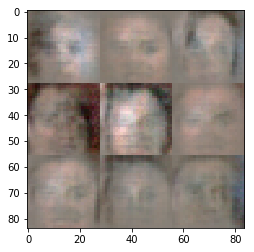

Epoch 2/5... Discriminator Loss: 1.3873... Generator Loss: 0.7199
Epoch 2/5... Discriminator Loss: 1.3936... Generator Loss: 0.6903
Epoch 2/5... Discriminator Loss: 1.3895... Generator Loss: 0.7068
Epoch 2/5... Discriminator Loss: 1.3848... Generator Loss: 0.6918
Epoch 2/5... Discriminator Loss: 1.3886... Generator Loss: 0.6924
Epoch 2/5... Discriminator Loss: 1.3887... Generator Loss: 0.6977
Epoch 2/5... Discriminator Loss: 1.3952... Generator Loss: 0.6867
Epoch 2/5... Discriminator Loss: 1.3850... Generator Loss: 0.7005
Epoch 2/5... Discriminator Loss: 1.3870... Generator Loss: 0.6939
Epoch 2/5... Discriminator Loss: 1.3906... Generator Loss: 0.7006


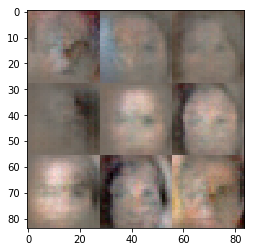

Epoch 2/5... Discriminator Loss: 1.3835... Generator Loss: 0.6958
Epoch 2/5... Discriminator Loss: 1.3914... Generator Loss: 0.6962
Epoch 2/5... Discriminator Loss: 1.3844... Generator Loss: 0.6848
Epoch 2/5... Discriminator Loss: 1.3931... Generator Loss: 0.7008
Epoch 2/5... Discriminator Loss: 1.3826... Generator Loss: 0.7261
Epoch 2/5... Discriminator Loss: 1.3862... Generator Loss: 0.7046
Epoch 3/5... Discriminator Loss: 1.3914... Generator Loss: 0.6991
Epoch 3/5... Discriminator Loss: 1.3826... Generator Loss: 0.7037
Epoch 3/5... Discriminator Loss: 1.3913... Generator Loss: 0.7224
Epoch 3/5... Discriminator Loss: 1.3872... Generator Loss: 0.6778


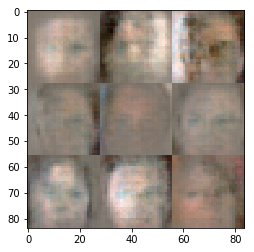

Epoch 3/5... Discriminator Loss: 1.3987... Generator Loss: 0.7095
Epoch 3/5... Discriminator Loss: 1.3842... Generator Loss: 0.6840
Epoch 3/5... Discriminator Loss: 1.3852... Generator Loss: 0.7071
Epoch 3/5... Discriminator Loss: 1.3784... Generator Loss: 0.7004
Epoch 3/5... Discriminator Loss: 1.3951... Generator Loss: 0.7050
Epoch 3/5... Discriminator Loss: 1.3851... Generator Loss: 0.6837
Epoch 3/5... Discriminator Loss: 1.3962... Generator Loss: 0.7095
Epoch 3/5... Discriminator Loss: 1.3872... Generator Loss: 0.6956
Epoch 3/5... Discriminator Loss: 1.3830... Generator Loss: 0.7048
Epoch 3/5... Discriminator Loss: 1.3902... Generator Loss: 0.6848


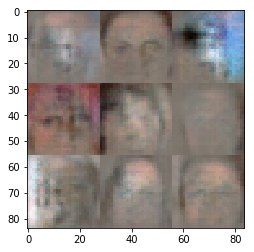

Epoch 3/5... Discriminator Loss: 1.3874... Generator Loss: 0.6901
Epoch 3/5... Discriminator Loss: 1.3833... Generator Loss: 0.6827
Epoch 3/5... Discriminator Loss: 1.3842... Generator Loss: 0.6965
Epoch 3/5... Discriminator Loss: 1.3918... Generator Loss: 0.6985
Epoch 3/5... Discriminator Loss: 1.3948... Generator Loss: 0.7089
Epoch 3/5... Discriminator Loss: 1.3876... Generator Loss: 0.6815
Epoch 3/5... Discriminator Loss: 1.3814... Generator Loss: 0.7000
Epoch 3/5... Discriminator Loss: 1.3809... Generator Loss: 0.6906
Epoch 3/5... Discriminator Loss: 1.3835... Generator Loss: 0.6770
Epoch 3/5... Discriminator Loss: 1.3943... Generator Loss: 0.7086


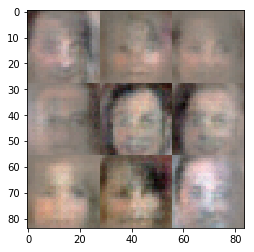

Epoch 3/5... Discriminator Loss: 1.3897... Generator Loss: 0.6949
Epoch 3/5... Discriminator Loss: 1.3850... Generator Loss: 0.6901
Epoch 3/5... Discriminator Loss: 1.3826... Generator Loss: 0.6991
Epoch 3/5... Discriminator Loss: 1.3888... Generator Loss: 0.7079
Epoch 3/5... Discriminator Loss: 1.3807... Generator Loss: 0.6720
Epoch 3/5... Discriminator Loss: 1.3979... Generator Loss: 0.7159
Epoch 3/5... Discriminator Loss: 1.3850... Generator Loss: 0.7182
Epoch 3/5... Discriminator Loss: 1.3873... Generator Loss: 0.7171
Epoch 3/5... Discriminator Loss: 1.3801... Generator Loss: 0.7086
Epoch 3/5... Discriminator Loss: 1.3892... Generator Loss: 0.7057


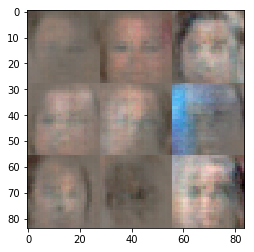

Epoch 3/5... Discriminator Loss: 1.3832... Generator Loss: 0.7029
Epoch 3/5... Discriminator Loss: 1.3935... Generator Loss: 0.7030
Epoch 3/5... Discriminator Loss: 1.3882... Generator Loss: 0.6885
Epoch 3/5... Discriminator Loss: 1.3852... Generator Loss: 0.7041
Epoch 3/5... Discriminator Loss: 1.3811... Generator Loss: 0.6940
Epoch 3/5... Discriminator Loss: 1.3870... Generator Loss: 0.6933
Epoch 3/5... Discriminator Loss: 1.4056... Generator Loss: 0.6988
Epoch 3/5... Discriminator Loss: 1.3899... Generator Loss: 0.7035
Epoch 3/5... Discriminator Loss: 1.3879... Generator Loss: 0.6974
Epoch 3/5... Discriminator Loss: 1.3914... Generator Loss: 0.6993


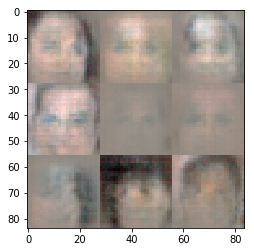

Epoch 3/5... Discriminator Loss: 1.3901... Generator Loss: 0.6974
Epoch 3/5... Discriminator Loss: 1.3878... Generator Loss: 0.6928
Epoch 3/5... Discriminator Loss: 1.3821... Generator Loss: 0.7000
Epoch 3/5... Discriminator Loss: 1.3859... Generator Loss: 0.6902
Epoch 3/5... Discriminator Loss: 1.3847... Generator Loss: 0.7010
Epoch 3/5... Discriminator Loss: 1.3833... Generator Loss: 0.6962
Epoch 3/5... Discriminator Loss: 1.3801... Generator Loss: 0.6891
Epoch 3/5... Discriminator Loss: 1.3973... Generator Loss: 0.7055
Epoch 3/5... Discriminator Loss: 1.3907... Generator Loss: 0.7005


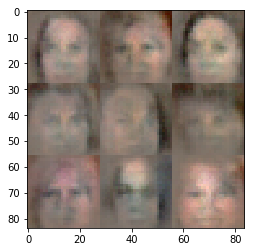

Epoch 3/5... Discriminator Loss: 1.3851... Generator Loss: 0.6900
Epoch 3/5... Discriminator Loss: 1.3916... Generator Loss: 0.7043
Epoch 3/5... Discriminator Loss: 1.3956... Generator Loss: 0.7138
Epoch 3/5... Discriminator Loss: 1.3868... Generator Loss: 0.7153
Epoch 3/5... Discriminator Loss: 1.3790... Generator Loss: 0.6912
Epoch 3/5... Discriminator Loss: 1.3890... Generator Loss: 0.6854
Epoch 3/5... Discriminator Loss: 1.3900... Generator Loss: 0.7100
Epoch 3/5... Discriminator Loss: 1.3797... Generator Loss: 0.6800
Epoch 3/5... Discriminator Loss: 1.3863... Generator Loss: 0.6951
Epoch 3/5... Discriminator Loss: 1.3867... Generator Loss: 0.6917


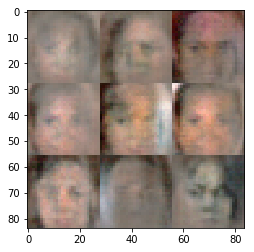

Epoch 3/5... Discriminator Loss: 1.3825... Generator Loss: 0.6964
Epoch 3/5... Discriminator Loss: 1.3889... Generator Loss: 0.7071
Epoch 3/5... Discriminator Loss: 1.3910... Generator Loss: 0.6927
Epoch 3/5... Discriminator Loss: 1.3903... Generator Loss: 0.7029
Epoch 3/5... Discriminator Loss: 1.3875... Generator Loss: 0.6766
Epoch 3/5... Discriminator Loss: 1.3939... Generator Loss: 0.6992
Epoch 3/5... Discriminator Loss: 1.3977... Generator Loss: 0.7254
Epoch 3/5... Discriminator Loss: 1.3861... Generator Loss: 0.7022
Epoch 3/5... Discriminator Loss: 1.3903... Generator Loss: 0.7014
Epoch 3/5... Discriminator Loss: 1.3930... Generator Loss: 0.6824


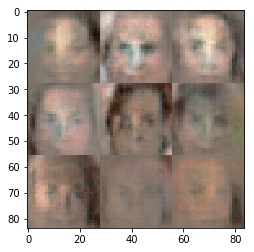

Epoch 3/5... Discriminator Loss: 1.4008... Generator Loss: 0.6728
Epoch 3/5... Discriminator Loss: 1.3912... Generator Loss: 0.6962
Epoch 3/5... Discriminator Loss: 1.3799... Generator Loss: 0.7020
Epoch 3/5... Discriminator Loss: 1.3791... Generator Loss: 0.6986
Epoch 3/5... Discriminator Loss: 1.3794... Generator Loss: 0.7097
Epoch 3/5... Discriminator Loss: 1.3764... Generator Loss: 0.7067
Epoch 3/5... Discriminator Loss: 1.3892... Generator Loss: 0.6942
Epoch 3/5... Discriminator Loss: 1.3857... Generator Loss: 0.6936
Epoch 3/5... Discriminator Loss: 1.3842... Generator Loss: 0.7070
Epoch 3/5... Discriminator Loss: 1.3814... Generator Loss: 0.6963


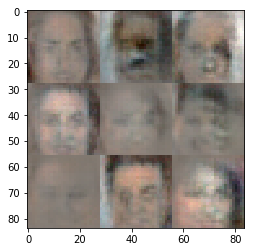

Epoch 3/5... Discriminator Loss: 1.3737... Generator Loss: 0.7028
Epoch 3/5... Discriminator Loss: 1.3844... Generator Loss: 0.6853
Epoch 3/5... Discriminator Loss: 1.3829... Generator Loss: 0.6877
Epoch 3/5... Discriminator Loss: 1.3892... Generator Loss: 0.7077
Epoch 3/5... Discriminator Loss: 1.3802... Generator Loss: 0.6965
Epoch 3/5... Discriminator Loss: 1.3987... Generator Loss: 0.7157
Epoch 3/5... Discriminator Loss: 1.3730... Generator Loss: 0.7300
Epoch 3/5... Discriminator Loss: 1.3725... Generator Loss: 0.7071
Epoch 3/5... Discriminator Loss: 1.3881... Generator Loss: 0.6923
Epoch 3/5... Discriminator Loss: 1.3733... Generator Loss: 0.6884


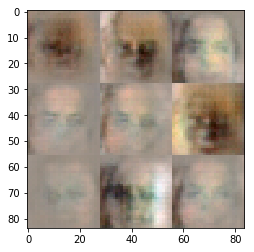

Epoch 3/5... Discriminator Loss: 1.3831... Generator Loss: 0.6880
Epoch 3/5... Discriminator Loss: 1.3912... Generator Loss: 0.6964
Epoch 3/5... Discriminator Loss: 1.3775... Generator Loss: 0.7117
Epoch 3/5... Discriminator Loss: 1.3832... Generator Loss: 0.6911
Epoch 3/5... Discriminator Loss: 1.3863... Generator Loss: 0.7221
Epoch 3/5... Discriminator Loss: 1.3959... Generator Loss: 0.7051
Epoch 3/5... Discriminator Loss: 1.3746... Generator Loss: 0.6831
Epoch 3/5... Discriminator Loss: 1.4013... Generator Loss: 0.7145
Epoch 3/5... Discriminator Loss: 1.3782... Generator Loss: 0.7070
Epoch 3/5... Discriminator Loss: 1.3741... Generator Loss: 0.6756


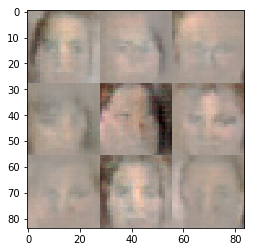

Epoch 3/5... Discriminator Loss: 1.3792... Generator Loss: 0.7037
Epoch 3/5... Discriminator Loss: 1.3779... Generator Loss: 0.6898
Epoch 3/5... Discriminator Loss: 1.3864... Generator Loss: 0.6997
Epoch 3/5... Discriminator Loss: 1.3759... Generator Loss: 0.6944
Epoch 3/5... Discriminator Loss: 1.3801... Generator Loss: 0.7224
Epoch 3/5... Discriminator Loss: 1.4026... Generator Loss: 0.6919
Epoch 3/5... Discriminator Loss: 1.4071... Generator Loss: 0.6688
Epoch 3/5... Discriminator Loss: 1.3803... Generator Loss: 0.7165


KeyboardInterrupt: 

In [ ]:
learning_rate = 0.0004
batch_size = 128
z_dim = 100
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.